# Random forest classification using the Dask library

CSC/Geoportti workshop, 16.5.2022

This notebook demos a simple land cover classification task using xarray, Dask and a local computing cluster.

This notebook can be run on CSC clusters, using only the geoconda module, without other environment installations.


Mikko Impiö, 2022

In [1]:
import dask
import rioxarray
import os

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rasterio as rio

from dask.diagnostics import ProgressBar
from dask.distributed import progress, wait

## Launching the local cluster and loading data

We launch a local cluster in order to track the computing progress using the Dask daskboard.

Some use-cases in local environments might benefit for using ```processes=False```, as it shares memory between workers resulting in smaller overhead. In distributed systems ```processes=True``` is most likely the best choice.

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39400")
client

<Client: 'tcp://127.0.0.1:39400' processes=2 threads=2, memory=16.00 GiB>

In [ ]:
from dask.distributed import Client, LocalCluster
threads_per_worker=1
cluster = LocalCluster(processes=True, 
                       threads_per_worker=threads_per_worker)
client = Client(cluster)
client.cluster

/users/impiomik/.local/lib/python3.9/site-packages/distributed/node.py:180: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36894 instead
  warnings.warn(


An important consideration during loading is the chunk size. [Dask documentation](https://docs.dask.org/en/stable/array-chunks.html) has a good guide on what to take to account when choosing a chunk size.

When using sklearn random forests a too small chunk size leads to a large computational graph while a too large chunk size might produce memory problems. With large graph sizes the intermediate outputs of ```predict_proba``` are saved in memory before merging, and can cause running out of memory. [This is an open bug](https://github.com/dask/dask/issues/5993) that should be fixed in the future. Experimenting with chunk sizes and splitting a very large rasters to "smaller" ones has worked in practice.

We load the raster to an xarray DataArray. The raster is not loaded to memory, so we can handle potentially terabyte-sized rasters easily. Only when computation is performed, is necessary chunks loaded to memory.

It is important to note that unit conversions and other computations done early in the computational graph can increase the size of the graph and slow down computations later. 

In [8]:
fname = os.path.abspath('demo_raster.tif')

chunk_s = 2**10
xds = rioxarray.open_rasterio(fname, 
                              chunks={'band': -1, 'x': chunk_s, 'y': chunk_s},
                              lock=False,
                              parallel=True)
xds

<xarray.DataArray (band: 9, y: 4000, x: 4000)>
dask.array<open_rasterio-f16256e490173c54c7d44f5ffe3064c1<this-array>, shape=(9, 4000, 4000), dtype=uint8, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9
  * x            (x) float64 4.792e+05 4.792e+05 ... 5.078e+05 5.078e+05
  * y            (y) float64 7.762e+06 7.762e+06 ... 7.734e+06 7.734e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

Let's calculate a smaller version of the above array. Imagine the array was sized much larger than what fits into computer memory, and we want to visualize it by subsampling it to a coarser version. 

In [9]:
coarse_xds = xds.coarsen(x=2, y=2, boundary='trim').mean()
coarse_xds

<xarray.DataArray (band: 9, y: 2000, x: 2000)>
dask.array<mean_agg-aggregate, shape=(9, 2000, 2000), dtype=float64, chunksize=(9, 512, 512), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9
  * x            (x) float64 4.792e+05 4.792e+05 ... 5.078e+05 5.078e+05
  * y            (y) float64 7.762e+06 7.762e+06 ... 7.734e+06 7.734e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:    0.0
    scale_factor:  1.0
    add_offset:    0.0

Let's see how the loaded raster looks. We have nine channels that are principal components of a larger data cube. The ```.compute()``` triggers the computation of the subsampling.

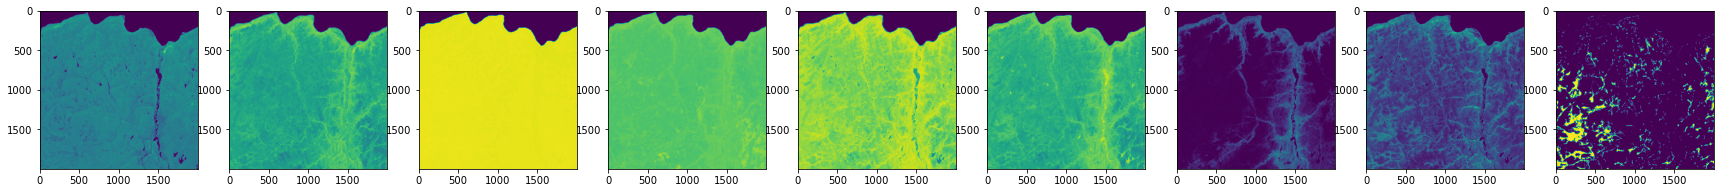

In [10]:
Fc = coarse_xds.compute()

fig, axs = plt.subplots(1,Fc.shape[0],figsize=(30,15))
for i, ax in enumerate(axs):
    ax.imshow(Fc[i,::])

## Data for machine learning

We have a preprocessed dataset containing 2793 field-collected datapoints. Each dataset row contains the pixel values of the above raster from the sample location. The class we want to predict is the [Inventointiluokka](https://julkaisut.metsa.fi/assets/pdf/lp/Bsarja/b57.pdf) biotope class code used by Metsähallitus.

In [6]:
df = pd.read_csv('demo_train_2.csv')
df

,Invluokka,feaMed1,feaMed2,feaMed3,feaMed4,feaMed5,feaMed6,feaMed7,feaMed8,suoMod
0,104,36.0,114.0,234.0,134.0,105.0,85.0,0.0,1.0,0.0
1,104,39.0,108.0,234.0,137.0,107.0,83.0,0.0,1.0,0.0
2,104,38.0,112.0,235.0,137.0,107.0,88.0,0.0,1.0,0.0
3,104,39.0,106.0,236.0,147.0,107.0,82.0,0.0,3.0,0.0
4,263,47.0,133.0,243.0,134.0,154.0,105.0,0.0,21.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2788,263,47.0,189.0,242.0,148.0,173.0,175.0,79.0,43.0,0.0
2789,263,51.0,190.0,243.0,145.0,178.0,172.0,88.0,40.0,0.0
2790,251,42.0,164.0,243.0,139.0,171.0,165.0,109.0,34.0,0.0
2791,251,46.0,175.0,244.0,141.0,174.0,173.0,102.0,37.0,0.0


There are 21 classes in this dataset, smallest with 13 samples - a highly unbalanced and difficult classification dataset

In [7]:
dfY = df.iloc[:,0]
dfX = df.iloc[:,1:]

print("\nTarget class distribution")
print("label\tcount")
print(dfY.value_counts())
print()

# Final dataset
X = dfX.to_numpy(dtype=xds.dtype)
y = dfY.to_numpy(dtype=xds.dtype)


Target class distribution
label	count
242    841
241    620
251    196
232    165
333    145
263    136
104     90
252     86
321     83
262     80
323     73
430     57
271     35
101     32
261     30
312     28
220     26
332     23
313     20
322     14
331     13
Name: Invluokka, dtype: int64



### Evaluation

This is an example of a hard, fine-grained classification problem. Using five-fold cross validation five times, the mean class-weighted F1-score (harmonic mean of precision and recall) is around 58%-59%.

Here we are **not** using Dask yet, but sklearn classifiers.

In [8]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                            cohen_kappa_score,
                            make_scorer)
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from skimage.color import label2rgb

seed = 42

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=seed)

scoring= {'accuracy': make_scorer(accuracy_score),
          'f1': make_scorer(f1_score, zero_division=0, average='weighted'),
          'precision': make_scorer(precision_score, zero_division=0, average='weighted'),
          'kappa': make_scorer(cohen_kappa_score)
         }

clf = RandomForestClassifier()

scores = cross_validate(clf, X, y, 
                        scoring=scoring,
                        cv=skf,
                        return_estimator=True,
                        verbose=2,
                        n_jobs=-1)
print(clf)
scores = pd.DataFrame(scores).drop(['fit_time', 'score_time', 'estimator'],axis=1)
print(scores.describe())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  25 | elapsed:    4.7s remaining:    5.1s


RandomForestClassifier()
       test_accuracy    test_f1  test_precision  test_kappa
count      25.000000  25.000000       25.000000   25.000000
mean        0.611168   0.585803        0.584451    0.524657
std         0.016493   0.016401        0.019169    0.020047
min         0.579606   0.554120        0.552843    0.487336
25%         0.596774   0.572137        0.565675    0.507232
50%         0.611111   0.584506        0.589192    0.523333
75%         0.623656   0.598365        0.598467    0.539938
max         0.642218   0.617526        0.617255    0.562257


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.4s finished


## Dask classifier

In order to use the Dask cluster, we need to make sure that all computation is done using functions that Dask can process. Dask has an excellent support for different machine learning tasks and supports most workflows.

Our situation is characterized by a [small training dataset](https://examples.dask.org/machine-learning/scale-scikit-learn.html), but potentially terabyte-sized inference dataset. We want to parallelize the prediction process with the ```ParallelPostFit```-class.

In [9]:
from dask_ml.wrappers import ParallelPostFit

clf_dask = ParallelPostFit(estimator=RandomForestClassifier(n_jobs=threads_per_worker))
clf_dask.fit(X, y)

ParallelPostFit(estimator=RandomForestClassifier(n_jobs=1))

In [10]:
import dask.array as da
F = da.asarray(xds)
F

dask.array<open_rasterio-35b39e63cbdf9c46e14ac217aaad6d95<this-array>, shape=(9, 4000, 4000), dtype=uint8, chunksize=(9, 1024, 1024), chunktype=numpy.ndarray>

The functions needed for Dask-parallelized inference on rasters of arbitary shapes. The functions ignore pixels where all values are zero, making the total inference process significantly faster and easier to handle.

In [11]:
def inference(a: dask.array, clf) -> dask.array:
    """Elementary prediction for an array 'a' using model 'clf'
    """
    c0 = clf.predict_proba(a)
    c = (254*c0).astype(np.uint8)
    return c

def read_masked_data(A: dask.array):
    """ Picks nonzero values along depth from A and returns rows of nonzero values
    and their index mask
    
    Performance depends highly on the mask rechunking size. If the chunk size is too large, memory 
    use per worker is too high, and if it is too low, chunks are probably copied across workers so
    that system memory usage is too high and SLURM job crashes.
    
    params
    A : array
    
    returns
    data: nonzero rows
    mask: row locations
    """

    A0 = da.moveaxis(A,0,2)
    ny, nx, chan = A0.shape
    a = A0.reshape(ny*nx, chan)

    mask = da.where(~da.all(a==0,axis=1))[0]
    mask.compute_chunk_sizes()
    mask = mask.rechunk((1e6,-1)) #inference float chunks get too big otherwise
    
    data = a[mask,:]
    return data, mask

def masked_inference(A: dask.array, clf)->dask.array:
    """Classifies nonzero pixels in an array using model 'clf'
    """
    
    # Masking
    data, mask = read_masked_data(A)
    
    # New data
    chan, ny, nx = A.shape
    c = da.zeros((ny*nx, len(clf.classes_)), dtype=np.uint8) #empty array for results
    
    # Inference
    if len(data)!=0:
        c0 = inference(data, clf)
        c[mask,:] = c0

    # Inverse reshape
    C = c.reshape(ny,nx, -1)
    C = da.moveaxis(C,2,0)
    
    return C

Because the computation graph depends on calculating the all-zero areas in the raster, calling the function triggers computations for calculating the graph. No actual inference is performed at this point, only the output raster size is calculated. As we can see, the depth of the array is now 21 - the number of classes. The output of the prediction probability is quantized to uint8, to produce smaller output rasters.

The final chunking is often sliced differently, and might need ```.rechunk()``` before writing on disk, if the array is very large.

In [13]:
C = masked_inference(F, clf_dask)
C

/users/impiomik/.local/lib/python3.9/site-packages/dask/array/slicing.py:1084: PerformanceWarning: Increasing number of chunks by factor of 15
  p = blockwise(


dask.array<transpose, shape=(21, 4000, 4000), dtype=uint8, chunksize=(21, 1000, 4000), chunktype=numpy.ndarray>

As we can see, inference with a small array of 16 million pixels takes about 30 seconds. This is faster, but still fairly close to sklearn. Dask is generally useful only with very large datasets that don't fit in memory. Usually even though the raster itself would be small, the output prediction array grows very large very fast if there are a lot of classes.

In [14]:
%%time
C_computed = C.compute()

CPU times: user 9.2 s, sys: 4.13 s, total: 13.3 s
Wall time: 33.3 s


Lets compute the most probable class and the maximum forest agreement (% of trees with the most likely class) and plot them. We could save the rasters to disk in a distributed manner, without loading the full prediction array to memory at any point.

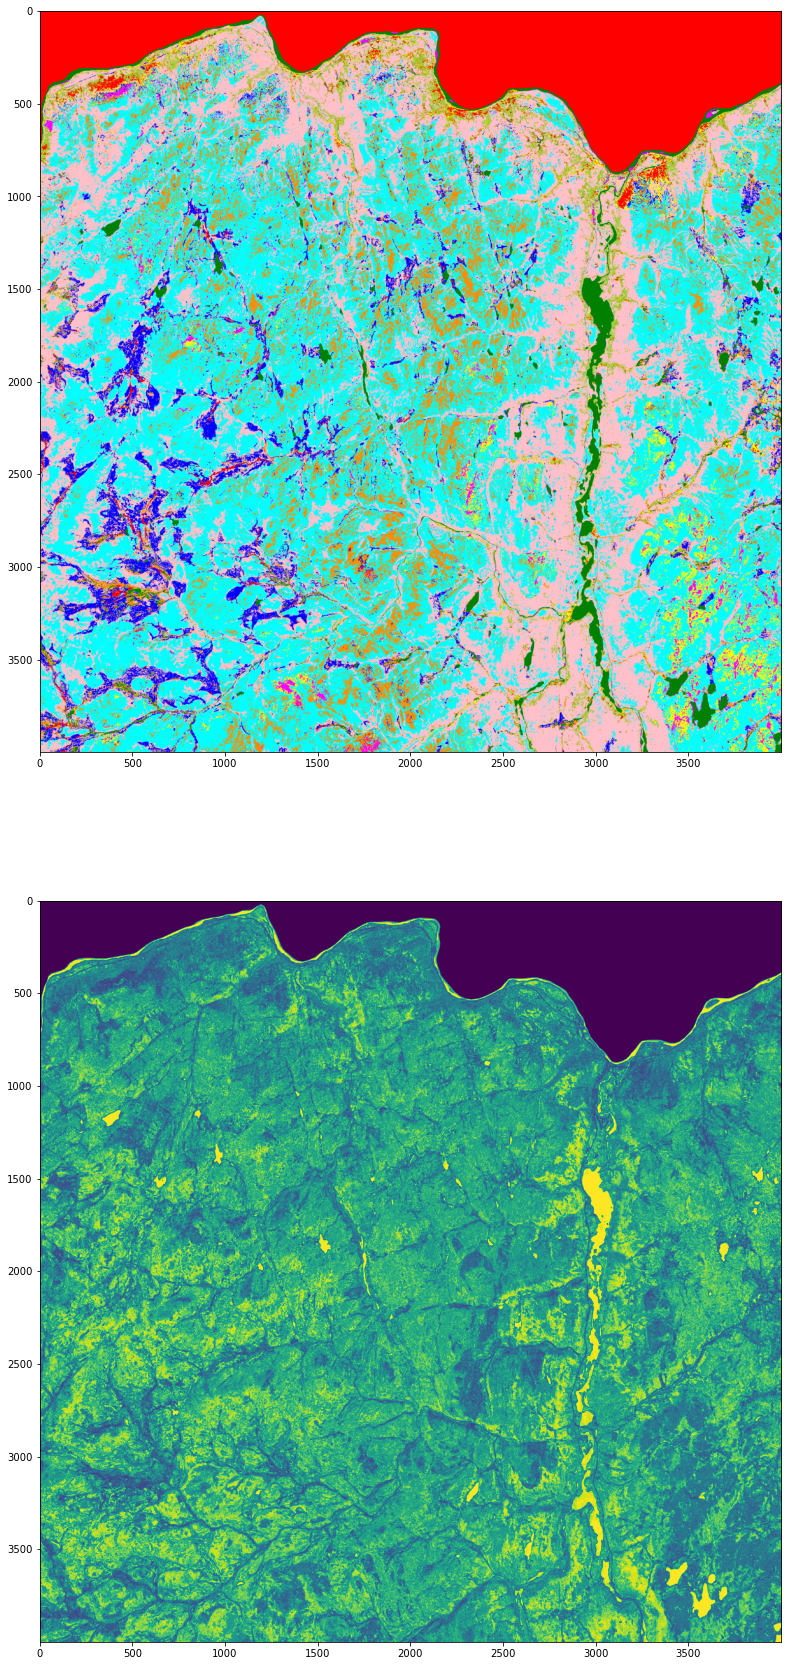

In [15]:
S = C_computed.argmax(axis=0)
M = C_computed.max(axis=0)

fig, ax = plt.subplots(2,1, figsize=(15,30))
ax[0].imshow(label2rgb(S, bg_label=-1))
ax[1].imshow(M)

# Comparison to in-memory inference

As a reference, the in-memory inference is much more simple, but does not work when the array size grows larger than memory.

In [ ]:
pixel_array = np.swapaxes(F.compute(),0,2)
pixel_array.shape

In [ ]:
pixel_array = pixel_array.reshape(4000*4000,9)
pixel_array.shape

In [ ]:
%%time
clf = RandomForestClassifier(verbose=1, n_jobs=-1)
clf.fit(X,y)
preds = clf.predict_proba(pixel_array)

In [ ]:
C2 = preds.reshape(4000,4000,clf.n_classes_)
C2.shape